In [1]:
import os

import pandas as pd
import matplotlib
# import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import rich.console
import rich.table

sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
experiments = [ "uc1-store-1-http-gcp", "uc1-store-1-pubsub-gcp", "uc3-aggregate-1-http-gcp", "uc3-aggregate-1-pubsub-gcp", "uc1-store-1-http-aws", "uc3-aggregate-1-http-aws", "uc1-store-1-http-gcp-go", "uc1-store-1-http-gcp-node", "uc3-aggregate-1-http-gcp-go", "uc3-aggregate-1-http-gcp-node" ]
# experiments = [ "uc1-store-1-http-aws", "uc3-aggregate-1-http-aws" ]

In [3]:
ramp_up_time = 60
run_length = 2 * 60

In [4]:
results_df = pd.DataFrame()
results_df_full = pd.DataFrame()

for e in experiments:
    run_file = os.path.join(os.getcwd(), "results", f"{e}.csv")
    run_df = pd.read_csv(run_file)

    run_df["timestamp"] = pd.to_datetime(run_df["timestamp"])
    run_df["timestamp"] = run_df["timestamp"].map(pd.Timestamp.timestamp)
    run_df["timestamp"] = (run_df["timestamp"] - min(run_df["timestamp"]))

    run_df_grouped = run_df.groupby(["executionId"]).agg({"price": "sum", "timestamp": "min"}).reset_index()

    # filter by run_length
    run_df_grouped = run_df_grouped[(run_df_grouped["timestamp"] > ramp_up_time) & (run_df_grouped["timestamp"] <= run_length + ramp_up_time)]

    run_df["run"] = e
    run_df_grouped["run"] = e

    results_df = results_df.append(run_df_grouped)
    results_df_full = results_df_full.append(run_df)

results_df.reset_index(inplace=True, drop=True)
results_df.head()

,executionId,price,timestamp,run
0,hi210wyogbvc,0.000175,91.611,uc1-store-1-http-gcp
1,hi2112s41hqm,0.000171,173.603,uc1-store-1-http-gcp
2,hi211cj8vmns,0.000171,126.603,uc1-store-1-http-gcp
3,hi211jj19o5e,0.000173,143.608,uc1-store-1-http-gcp
4,hi211p66hfi1,0.000171,85.604,uc1-store-1-http-gcp


In [5]:
results_df_full.reset_index(inplace=True, drop=True)
results_df_full.head()

,timestamp,type,price,executionId,run
0,0.000000,WRITE,0.000117,hi21jeycmow6,uc1-store-1-http-gcp
1,0.096359,INVOCATION,0.000040,hi21jeycmow6,uc1-store-1-http-gcp
2,0.096359,TIME,0.005008,hi21jeycmow6,uc1-store-1-http-gcp
3,0.393000,WRITE,0.000117,hi21ukboyi5q,uc1-store-1-http-gcp
4,0.394160,INVOCATION,0.000040,hi21ukboyi5q,uc1-store-1-http-gcp


In [6]:
results_df_full = results_df_full.groupby(["type", "executionId", "run"]).agg({"price": "sum"}).reset_index()
results_df_full.head()

,type,executionId,run,price
0,INVOCATION,003db073-0787-4ea7-96c3-0d7f2265e19d,uc3-aggregate-1-http-aws,0.00002
1,INVOCATION,01f279e9-5081-48fd-b40d-2ad37b38ab61,uc3-aggregate-1-http-aws,0.00002
2,INVOCATION,02379be1-ecae-4f2e-928a-5c1eaa887b44,uc1-store-1-http-aws,0.00002
3,INVOCATION,031098c5-2ab7-4aae-8669-48d1f31c3a47,uc3-aggregate-1-http-aws,0.00002
4,INVOCATION,03161fbd-123a-4a46-951c-3675de30415a,uc1-store-1-http-aws,0.00002


<AxesSubplot:xlabel='timestamp', ylabel='price'>

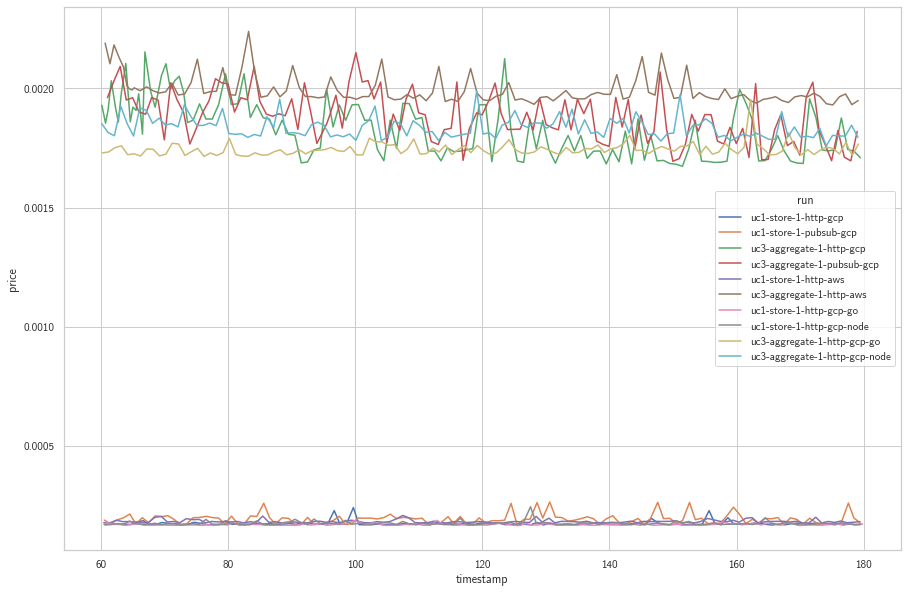

In [7]:
sns.lineplot(x="timestamp", y="price", hue="run", data=results_df, ci=None)

<AxesSubplot:xlabel='price', ylabel='Proportion'>

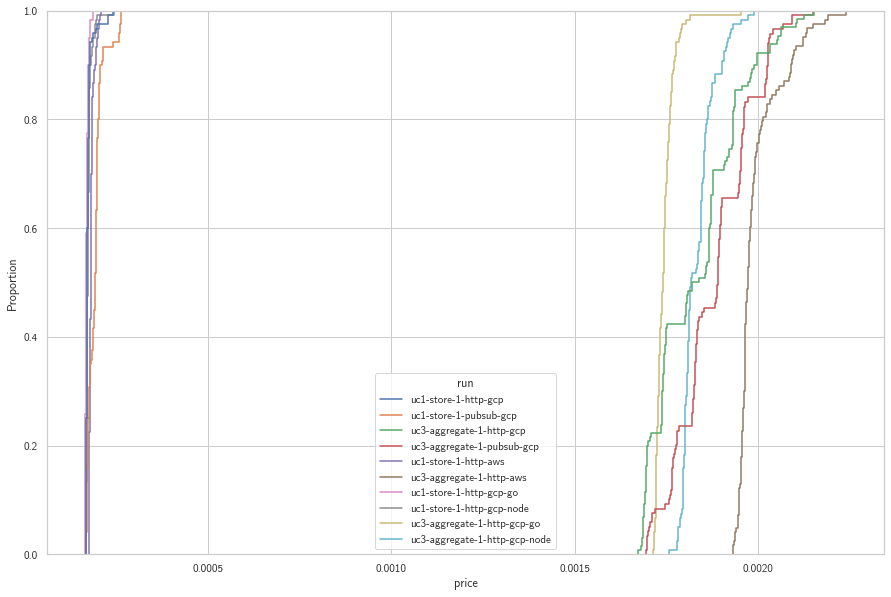

In [8]:
sns.ecdfplot(data=results_df, x="price", hue="run")

In [9]:
invocation_cost = {}
duration_cost = {}
fs_write_cost = {}
fs_read_cost = {}
transport_cost = {}

for e in experiments:

    # using median for functions, since that should let us remove any outliers
    invocation_cost[e] = results_df_full[(results_df_full["run"] == e) &(results_df_full['type'] == 'INVOCATION')]['price'].median() * 1 * 60 * 60 / 100
    duration_cost[e] = results_df_full[(results_df_full["run"] == e) &(results_df_full['type'] == 'TIME')]['price'].median() * 1 * 60 * 60 / 100

    # using mean here to capture full effect of different invocations, there shouldnt be any outliers
    fs_write_cost[e] = results_df_full[(results_df_full["run"] == e) &(results_df_full['type'] == 'WRITE')]['price'].mean() * 1 * 60 * 60 / 100
    fs_read_cost[e] = results_df_full[(results_df_full["run"] == e) &(results_df_full['type'] == 'READ')]['price'].mean() * 1 * 60 * 60 / 100

    transport_cost[e] = (40/(1024*1024*1024*1024))*1000 * 1 * 60 * 60 if "pubsub" in e else 0

    # if any of the cost is nan, it should be 0
    if np.isnan(invocation_cost[e]):
        invocation_cost[e] = 0
    if np.isnan(duration_cost[e]):
        duration_cost[e] = 0
    if np.isnan(fs_write_cost[e]):
        fs_write_cost[e] = 0
    if np.isnan(fs_read_cost[e]):
        fs_read_cost[e] = 0


In [10]:
table = rich.table.Table(title="Costs")

table.add_column("Use-Case")
table.add_column("Access Method")
table.add_column("Platform")
table.add_column("Runtime")
table.add_column("Invocation")
table.add_column("Duration")
table.add_column("DB Write")
table.add_column("DB Read")
table.add_column("Transport")

for e in experiments:
    table.add_row("UC1" if "uc1" in e else "UC3", "Pub/Sub" if "pubsub" in e else "HTTP", "AWS" if "aws" in e else "GCP", "Go" if "go" in e else "Node.js" if "node" in e else "Java", f"${invocation_cost[e]:.10f}", f"${duration_cost[e]:.10f}", f"${fs_write_cost[e]:.10f}", f"${fs_read_cost[e]:.10f},", f"${transport_cost[e]:.10f}")

console = rich.console.Console()
console.print(table)

                                            Costs                                            
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃         ┃ Access  ┃         ┃         ┃         ┃          ┃ DB      ┃          ┃         ┃
┃ Use-Ca… ┃ Method  ┃ Platfo… ┃ Runtime ┃ Invoca… ┃ Duration ┃ Write   ┃ DB Read  ┃ Transp… ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ UC1     │ HTTP    │ GCP     │ Java    │ $0.001… │ $0.0005… │ $0.004… │ $0.0000… │ $0.000… │
│ UC1     │ Pub/Sub │ GCP     │ Java    │ $0.001… │ $0.0013… │ $0.004… │ $0.0000… │ $0.000… │
│ UC3     │ HTTP    │ GCP     │ Java    │ $0.001… │ $0.0100… │ $0.042… │ $0.0141… │ $0.000… │
│ UC3     │ Pub/Sub │ GCP     │ Java    │ $0.001… │ $0.0108… │ $0.042… │ $0.0141… │ $0.000… │
│ UC1     │ HTTP    │ AWS     │ Java    │ $0.000… │ $0.0003… │ $0.005… │ $0.0000… │ $0.000… │
│ UC3     │ HTTP    │ AWS     │ Java    │ $0.000… │ $0.0053… │ $0.054… │ $0.0109… │ $0.000… │
│ UC1     │ HTTP    │ GCP     │ Go      │ $0.001… │ $0.0003… │ $0.004… │ $0.0000… │ $0.000… │
│ UC1     │ HTTP    │ GCP     │ Node.js │ $0.001… │ $0.0005… │ $0.004… │ $0.0000… │ $0.000… │
│ UC3     │ HTTP    │ GCP     │ Go      │ $0.001… │ $0.0049… │ $0.042… │ $0.0141… │ $0.000… │
│ UC3     │ HTTP    │ GCP     │ Node.js │ $0.001… │ $0.0088… │ $0.042… │ $0.0140… │ $0.000… │
└─────────┴─────────┴─────────┴─────────┴─────────┴──────────┴─────────┴──────────┴─────────┘

In [11]:
table = rich.table.Table(title="Costs per Hour", show_lines=True)

table.add_column("Use-Case", vertical="middle")
table.add_column("Access Method", vertical="middle")
table.add_column("Platform", vertical="middle")
table.add_column("Runtime", vertical="middle")
table.add_column("Costs ($/hr)", vertical="middle")

for e in experiments:
    e_table = rich.table.Table(show_edge=False)
    e_table.add_column("Rate (req/s)")
    e_table.add_column("Invocation")
    e_table.add_column("Duration")
    e_table.add_column("DB Write")
    e_table.add_column("DB Read")
    e_table.add_column("Transport")
    e_table.add_column("Total w/o DB")
    e_table.add_column("Total")

    for rate in range(200, 1201, 200):
        e_table.add_row(f"{rate}", f"{invocation_cost[e] * rate:.5f}", f"{duration_cost[e] * rate:.5f}", f"{fs_write_cost[e] * rate:.5f}", f"{fs_read_cost[e] * rate:.5f}", f"{transport_cost[e] * rate:.5f}", f"{(invocation_cost[e] * rate) + (duration_cost[e] * rate) + (transport_cost[e] * rate):.5f}", f"{(invocation_cost[e] * rate) + (duration_cost[e] * rate) + (fs_write_cost[e] * rate) + (fs_read_cost[e] * rate) + (transport_cost[e] * rate):.5f}")

    table.add_row("UC1" if "uc1" in e else "UC3", "Pub/Sub" if "pubsub" in e else "HTTP" , "AWS" if "aws" in e else "GCP", "Go" if "go" in e else "Node.js" if "node" in e else "Java", e_table)

console = rich.console.Console()
console.width = 120
console.print(table)


                                                     Costs per Hour                                                     
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Use-Case ┃ Access Method ┃ Platform ┃ Runtime ┃ Costs ($/hr)                                                         ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          │               │          │         │         ┃        ┃       ┃        ┃       ┃        ┃ Total ┃         │
│          │               │          │         │  Rate   ┃        ┃       ┃ DB     ┃ DB    ┃        ┃ w/o   ┃         │
│          │               │          │         │  (req/… ┃ Invoc… ┃ Dura… ┃ Write  ┃ Read  ┃ Trans… ┃ DB    ┃ Total   │
│          │               │          │         │ ━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━ │
│ UC1      │ HTTP          │ GCP      │ Java    │  200    │ 0.288… │ 0.10… │ 0.842… │ 0.00… │ 0.000… │ 0.39… │ 1.233…  │
│          │               │          │         │  400    │ 0.576… │ 0.20… │ 1.684… │ 0.00… │ 0.000… │ 0.78… │ 2.466…  │
│          │               │          │         │  600    │ 0.864… │ 0.30… │ 2.527… │ 0.00… │ 0.000… │ 1.17… │ 3.699…  │
│          │               │          │         │  800    │ 1.152… │ 0.41… │ 3.369… │ 0.00… │ 0.000… │ 1.56… │ 4.932…  │
│          │               │          │         │  1000   │ 1.440… │ 0.51… │ 4.212… │ 0.00… │ 0.000… │ 1.95… │ 6.165…  │
│          │               │          │         │  1200   │ 1.728… │ 0.61… │ 5.054… │ 0.00… │ 0.000… │ 2.34… │ 7.398…  │
├──────────┼───────────────┼──────────┼─────────┼──────────────────────────────────────────────────────────────────────┤
│          │               │          │         │         ┃        ┃       ┃        ┃       ┃        ┃ Total ┃         │
│          │               │          │         │  Rate   ┃        ┃       ┃ DB     ┃ DB    ┃        ┃ w/o   ┃         │
│          │               │          │         │  (req/… ┃ Invoc… ┃ Dura… ┃ Write  ┃ Read  ┃ Trans… ┃ DB    ┃ Total   │
│          │               │          │         │ ━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━ │
│ UC1      │ Pub/Sub       │ GCP      │ Java    │  200    │ 0.288… │ 0.26… │ 0.842… │ 0.00… │ 0.026… │ 0.57… │ 1.417…  │
│          │               │          │         │  400    │ 0.576… │ 0.52… │ 1.684… │ 0.00… │ 0.052… │ 1.15… │ 2.835…  │
│          │               │          │         │  600    │ 0.864… │ 0.78… │ 2.527… │ 0.00… │ 0.078… │ 1.72… │ 4.253…  │
│          │               │          │         │  800    │ 1.152… │ 1.04… │ 3.369… │ 0.00… │ 0.104… │ 2.30… │ 5.671…  │
│          │               │          │         │  1000   │ 1.440… │ 1.30… │ 4.212… │ 0.00… │ 0.130… │ 2.87… │ 7.089…  │
│          │               │          │         │  1200   │ 1.728… │ 1.56… │ 5.054… │ 0.00… │ 0.157… │ 3.45… │ 8.507…  │
├──────────┼───────────────┼──────────┼─────────┼──────────────────────────────────────────────────────────────────────┤
│          │               │          │         │  Rate   ┃        ┃        ┃ DB    ┃ DB     ┃       ┃ Total  ┃        │
│          │               │          │         │  (req/… ┃ Invoc… ┃ Durat… ┃ Write ┃ Read   ┃ Tran… ┃ w/o DB ┃ Total  │
│          │               │          │         │ ━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━ │
│          │               │          │         │  200    │ 0.288… │ 2.001… │ 8.42… │ 2.821… │ 0.00… │ 2.289… │ 13.5…  │
│ UC3      │ HTTP          │ GCP      │ Java    │  400    │ 0.576… │ 4.003… │ 16.8… │ 5.643… │ 0.00… │ 4.579… │ 27.0…  │
│          │               │          │         │  600    │ 0.864… │ 6.004… │ 25.2… │ 8.465… │ 0.00… │ 6.868… │ 40.6…  │
│          │               │          │         │  800    │ 1.152… │ 8.006… │ 33.6… │ 11.28… │ 0.00… │ 9.158… │ 54.1…  │
│      

In [12]:
with open("faas-results.csv", "w") as f:
    f.write("benchmark,source,platform,runtime,load,invocation_cost,duration_cost,fs_write_cost,fs_read_cost,transport_cost,total_cost\n")
    for e in experiments:
        for rate in range(0, 1201, 100):
            f.write(f'{"uc1" if "uc1" in e else "uc3"},{"pubsub" if "pubsub" in e else "http"},{"aws" if "aws" in e else "gcp"},{"go116" if "go" in e else "nodejs16" if "node" in e else "java11"},{rate},{invocation_cost[e] * rate:.5f},{duration_cost[e] * rate:.5f},{fs_write_cost[e] * rate:.5f},{fs_read_cost[e] * rate:.5f},{transport_cost[e] * rate:.5f},{(invocation_cost[e] * rate) + (duration_cost[e] * rate) + (fs_write_cost[e] * rate) + (fs_read_cost[e] * rate) + (transport_cost[e] * rate):.5f}\n')